# Marketing campaign

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go


from  sklearn.ensemble import IsolationForest
import re

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

KeyboardInterrupt: 

## 1. Problem definition

A bank initiated the marketing campaign among its clients to deposit money. After it was finished, the management decided to identfy success factors of the campaign using machine learning algorythm to increase its efficiency and decrease costs.

## 2. EDA

### Bank client data:

* **Age** (numeric)
* **Job** : type of job (categorical: 'admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management', 'retired', 'self-employed', 'services', 'student', 'technician', 'unemployed', 'unknown')
* **Marital** : marital status (categorical: 'divorced', 'married', 'single', 'unknown' ; note: 'divorced' means divorced or widowed)
* **Education** (categorical: 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'illiterate', 'professional.course', 'university.degree', 'unknown')
* **Default**: has credit in default? (categorical: 'no', 'yes', 'unknown')
* **Housing**: has housing loan? (categorical: 'no', 'yes', 'unknown')
* **Loan**: has personal loan? (categorical: 'no', 'yes', 'unknown')
* 
### Related with the last contact of the current campaign:

* **Contact**: contact communication type (categorical:
'cellular','telephone')
* **Month**: last contact month of year (categorical: 'jan', 'feb', 'mar', …, 'nov', 'dec')
* **Day_of_week**: last contact day of the week (categorical:
'mon','tue','wed','thu','fri')
* **Duration**: last contact duration, in seconds (numeric). Important
note: this attribute highly affects the output target (e.g., if
duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known.
Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic
predictive model.


### Other attributes:

* **Campaign**: number of contacts performed during this campaign and for this client (numeric, includes last contact)
* **Pdays**: number of days that passed by after the client was last
contacted from a previous campaign (numeric; 999 means client was not previously contacted)
* **Previous**: number of contacts performed before this campaign and for this client (numeric)
* **Poutcome**: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
Social and economic context attributes.

### Target value:

* **deposit** : has the client subscribed a term deposit? (binary: 'yes', 'no')

In [ ]:
df = pd.read_csv('data/bank_fin.zip', sep = ';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


Let us look for missing entries

In [ ]:
cols_null_percent = df.isna().mean()*100
cols_null = cols_null_percent[cols_null_percent > 0].sort_values(ascending=False)
display(cols_null)

balance    0.223974
dtype: float64

In [ ]:
df['balance'].isna().value_counts()

False    11137
True        25
Name: balance, dtype: int64

Luckily only 'balance' feature contains 25 missing data entries. 

### Задание 2

Есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?

In [ ]:
df['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

It is likely missed values in the 'job'feature marked as 'unknown'

### Задание 3

преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)

In [ ]:
df['balance'].head()

0     2 343,00 $ 
1        45,00 $ 
2     1 270,00 $ 
3     2 476,00 $ 
4       184,00 $ 
Name: balance, dtype: object

We can see that values ends with ',00 $'. Special symbols and spaces must be removed; commas  should be replaced to dots. At last, we will change column type to numerical.

In [ ]:
df['balance'] = df['balance'].apply(lambda x: str(x).replace(' ', '')\
    .replace('$', '').replace(',', '.')).astype('float')
    
print(df['balance'].mean().round(3))
print(df['balance'].dtype)

1529.129
float64


### Задание 4

обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку

In [ ]:
# fill empty values with median
df['balance'] = df['balance'].fillna(df['balance'].median())
df['balance'].isna().value_counts()

print('Mean balance: {} $'.format(df['balance'].mean().round(3)))

Mean balance: 1526.936 $


### Задание 5

обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения

In [ ]:
# Clean 'job' feature
df['job'] = df['job'].apply(lambda x:  df['job'].mode()[0] if x=='unknown' else x)
df['job'].mode()[0]

'management'

In [ ]:
df['education'].value_counts()

secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: education, dtype: int64

In [ ]:
# Clean 'education' feature
df['education'] = df['education'].apply(lambda x:  df['education'].mode()[0] if x=='unknown' else x)
df['education'].mode()[0]

'secondary'

In [ ]:
#средний баланс для клиентов с самой популярной работой и самым популярным уровнем образования
print('Mean balance of clients with popular profession and education level: {} $'.\
    format(df[(df['job'] == 'management') & (df['education'] == 'secondary')]['balance'].mean().round(3)))

Mean balance of clients with popular profession and education level: 1598.883 $


### Задание 6

In [ ]:
# удалите все выбросы для признака balance

def outliers_tukey(data, feature, log_scale=False):
    """
    Identification of outliers by J.Tukey method
    - DataFrame;
    - feature to process
    - log_scale. If True, the data will be in the log scale else not.
    """
    if log_scale:
        x = np.log(data[feature])
    else:
        x = data[feature]
        
    IQR = data[feature].quantile(.75) - df['balance'].quantile(.25)
  
    lower_bound = data[feature].quantile(.25) - 1.5*IQR
    upper_bound = data[feature].quantile(.75) + 1.5*IQR 
    
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x > lower_bound) & (x < upper_bound)]
    print('Boundaries: ',lower_bound.round(), upper_bound.round())
    return outliers, cleaned

outliers, data = outliers_tukey(df, 'balance')
print(f'Number of outliers: {outliers.shape[0]}')

data

Boundaries:  -2241.0 4063.0
Number of outliers: 1057


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,1.0,yes,no,cellular,20,apr,257,1,-1,0,unknown,no
11158,39,services,married,secondary,no,733.0,no,no,unknown,16,jun,83,4,-1,0,unknown,no
11159,32,technician,single,secondary,no,29.0,no,no,cellular,19,aug,156,2,-1,0,unknown,no
11160,43,technician,married,secondary,no,0.0,no,yes,cellular,8,may,9,2,172,5,failure,no


In [ ]:
data.shape

(10104, 17)

## Часть 2:  Разведывательный анализ

### Задание 1
изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат

no     5423
yes    4681
Name: deposit, dtype: int64


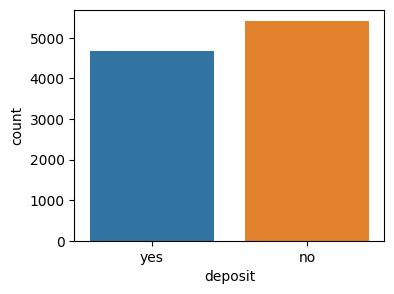

In [ ]:
fig = plt.figure(figsize=(4, 3))
sns.countplot(data = data, x='deposit');
print(data['deposit'].value_counts())

Classes of the target value are almost balanced.

### Задания 2 и 3
рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат

In [ ]:
# selection of numerical features
num_features = [s for s in data.columns if data[s].dtypes != 'object']
data[num_features].describe().T

,count,mean,std,min,25%,50%,75%,max
age,10104.0,40.895487,11.735511,18.0,32.0,38.0,48.00,95.0
balance,10104.0,807.331354,993.673452,-2049.0,95.0,444.5,1224.75,4062.0
day,10104.0,15.590657,8.441852,1.0,8.0,15.0,22.00,31.0
duration,10104.0,368.777712,346.650712,2.0,137.0,252.0,490.00,3881.0
campaign,10104.0,2.516924,2.707180,1.0,1.0,2.0,3.00,43.0
pdays,10104.0,51.307700,109.643031,-1.0,-1.0,-1.0,2.00,854.0
previous,10104.0,0.816112,2.243875,0.0,0.0,0.0,1.00,58.0
color,10104.0,0.463282,0.498675,0.0,0.0,0.0,1.00,1.0
deposit_outcome,10104.0,0.463282,0.498675,0.0,0.0,0.0,1.00,1.0


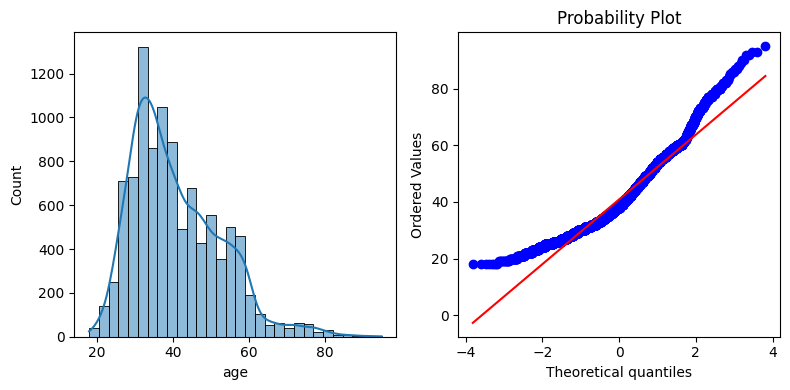

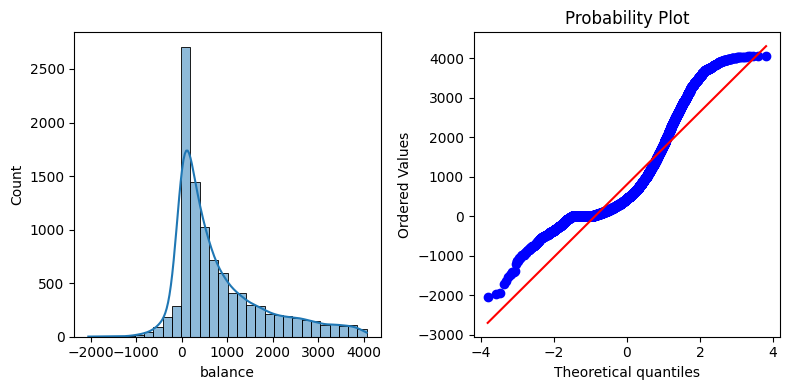

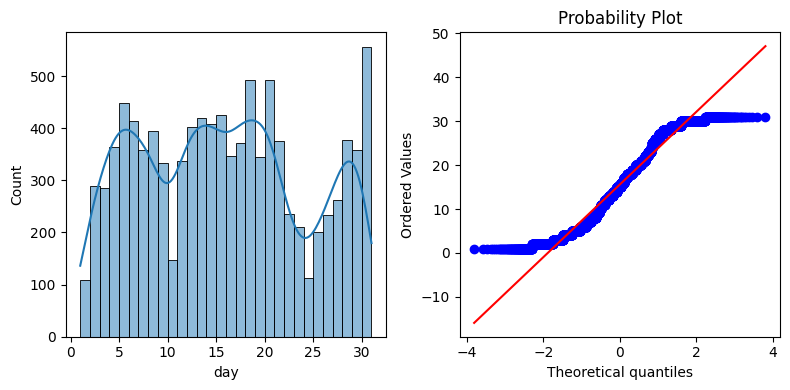

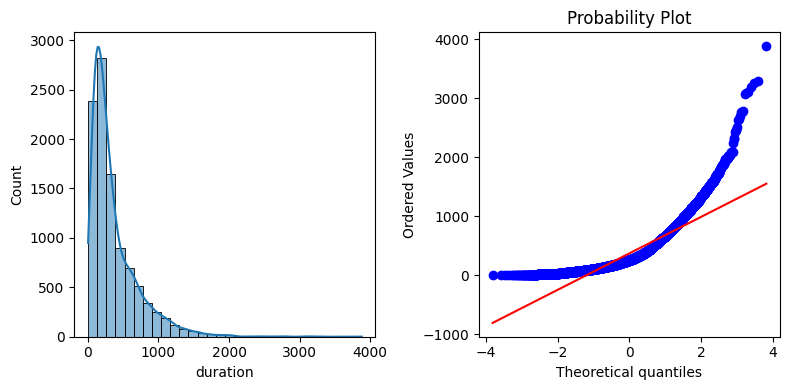

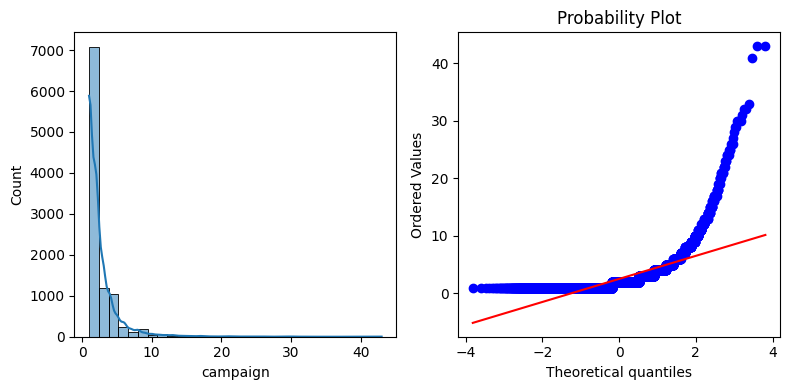

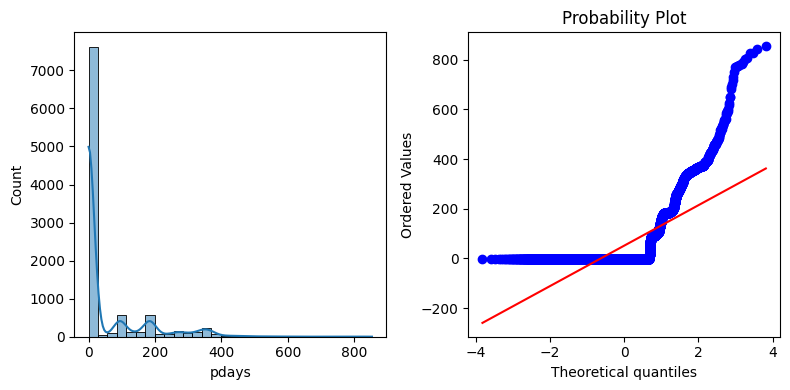

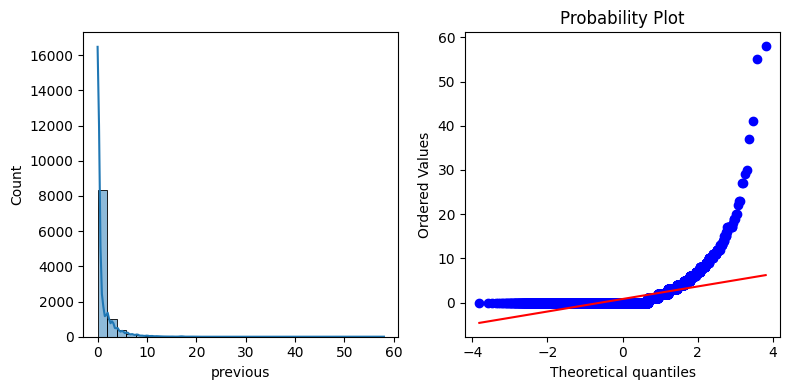

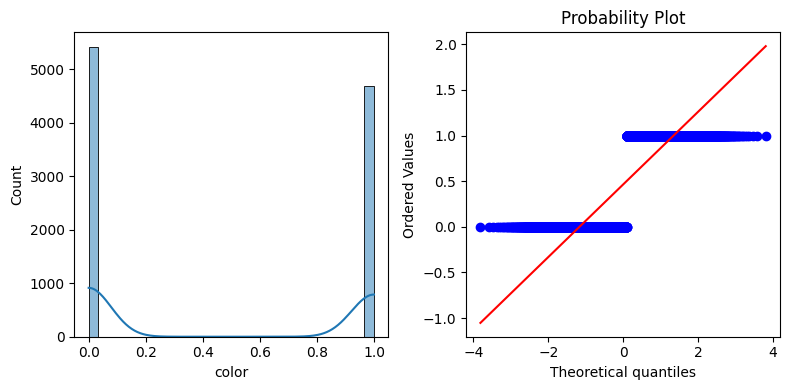

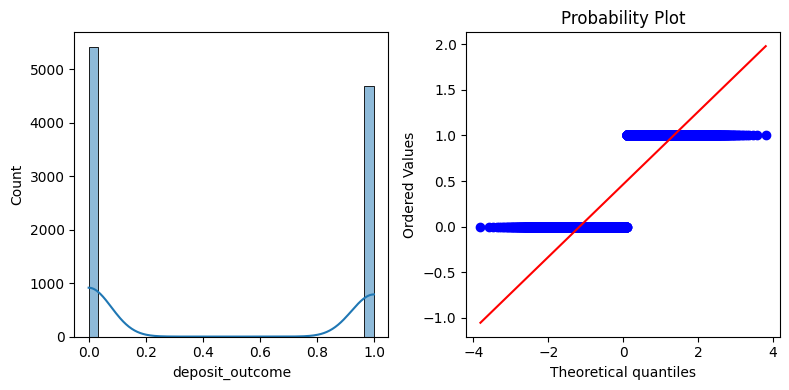

In [ ]:
from scipy import stats

def qq_plot(data, features):
    for i in data[features]:
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
        plt.subplot(1, 2, 1) 
        sns.histplot(data[i], kde=True, bins=30) # histogram

        plt.subplot(1, 2, 2) 
        stats.probplot(data[i], plot=plt) # qq plot

        plt.tight_layout() 

qq_plot(data, num_features)
#plt.show()

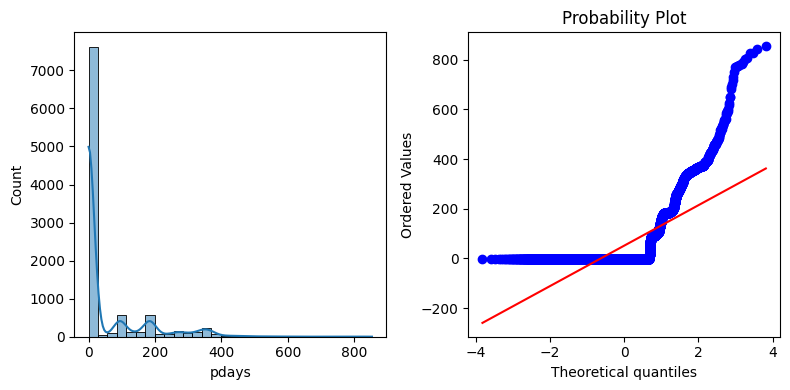

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
plt.subplot(1, 2, 1) 
sns.histplot(data['pdays'], kde=True, bins=30) # histogram

plt.subplot(1, 2, 2) 
stats.probplot(data['pdays'], plot=plt) # qq plot

plt.tight_layout() 

In [ ]:
fig = make_subplots(rows=2, cols=1, shared_xaxes=True )
    
fig.add_trace(go.Box(x=data['pdays'], name='original'), row=1, col=1)
fig.add_trace(go.Box(x=data[data['pdays'] >0]['pdays'], name='excluding -1 class'), row=2, col=1, )

fig.update_layout(legend_title_text ='Pdays feature', xaxis2_title_text='Days')


In [ ]:
fig = make_subplots(rows=2, cols=1, shared_xaxes=True )
    
fig.add_trace(go.Box(x=data['previous'], name='original'), row=1, col=1)
fig.add_trace(go.Box(x=data[data['previous'] >0]['previous'], name='excluding 0 class'), row=2, col=1, )

fig.update_layout(legend_title_text ='previous feature', xaxis2_title_text='Days')


Feature study:
* **age** - максимальный возраст клиента 95 лет, что подозрительно высоко. Возможно, что это выброс. Распределение данных лог-нормального вида с положительной ассимметрией указывает на то, что более половины клиентов старшего возраста: $40.8 \pm 11.7$ лет. Возраст практически независим от целевой переменной.
* **balance** - Распределение данных лог-нормального вида с положительной ассимметрией. В среднем на балансе клиентов находятся очень небольшие суммы: [-2049;4062] $ c пиком в районе $0. Большинство клиентов имеют положитеьный балансю Дискретный признак имеет слабую положительную связь с целевой переменной.
* **day** - день месяца(?), в который был последний контакт. Признак имеет неравномерное прямоугольное распределение. Низакая активность клиентов наблюдается на 11 и 24, тогда как высокая - в районе 6, 20 и 30 дней.  
* **duration** - распределение лог-нормальное с сильной положительной ассимметрией. В среднем контакт с клиентами длился $6 \pm 6$ мин (или $369 \pm 365$ сек.). Медианное время контакта довольно непродолжительное и составляет 4,2 мин (или 252 сек). Минимальная и максимальная длительности разговора - 2 и 3881 сек(1 час 4 мин) соответственно. Крайние значения, скорее всего, являются выбросами. Признак слабо коррелирует с целевым (коэффициент корреляции 0,45).
* **campaign** - количество контактов с клиентом во время текущей компании есть дискретная случайная величина, которая распределена не нормально. С каждым клиентом контактировали минимум 1 раз, а в среднем $2.5 \pm 2.7$ раз. Максимум контактов с кодним клиентом - 43 раза, что похоже на выброс. Количество контактов очень слабо отрицательно коррелирует с целевой переменной. Это можно интерпретировать так, что часть клиентов отказалась от депозита после контакта с сотрудниками, проводившими маркетинговую компанию.
* **pdays** - кол-во пропущенных количество дней от последней маркетинговой компании до контакта имеет неравномерное прямоугольное распределение. Признак распределен ненормально: имеет положительную ассимметрию и множество выбросов. Данные совокупности находятся  в диапазоне [-1; 854]. Предположим, что под отрицательными значениями понимается отсутстви контактов с клиентом. Если их не учитывать, то медианное время составляет $182 \pm 123$ дня. Признак очень слабо положительно коррелирует с целевой переменной,- открытие депозита. Это может означать, что контакт с клиентом положительно влияет на открытие депозита.
* **previous** - количество контактов с клиентом до текущей компании. С подавляющим большинством клиентов совокупности контактов не было. Признак имеет лог-нормальное распределение и содержит множество выбросов. Если не учитывать клиентов, с которыми контактировали впервые, то медианное количество контактов равно 2. Признак очень слабо положительно коррелирует с целевой переменной.

In [ ]:
data['deposit_outcome'] = data['deposit'].apply(lambda x: 1 if x=='yes' else 0)

In [ ]:
data[['previous', 'deposit_outcome']].corr()['deposit_outcome'][0].round(2)

0.14

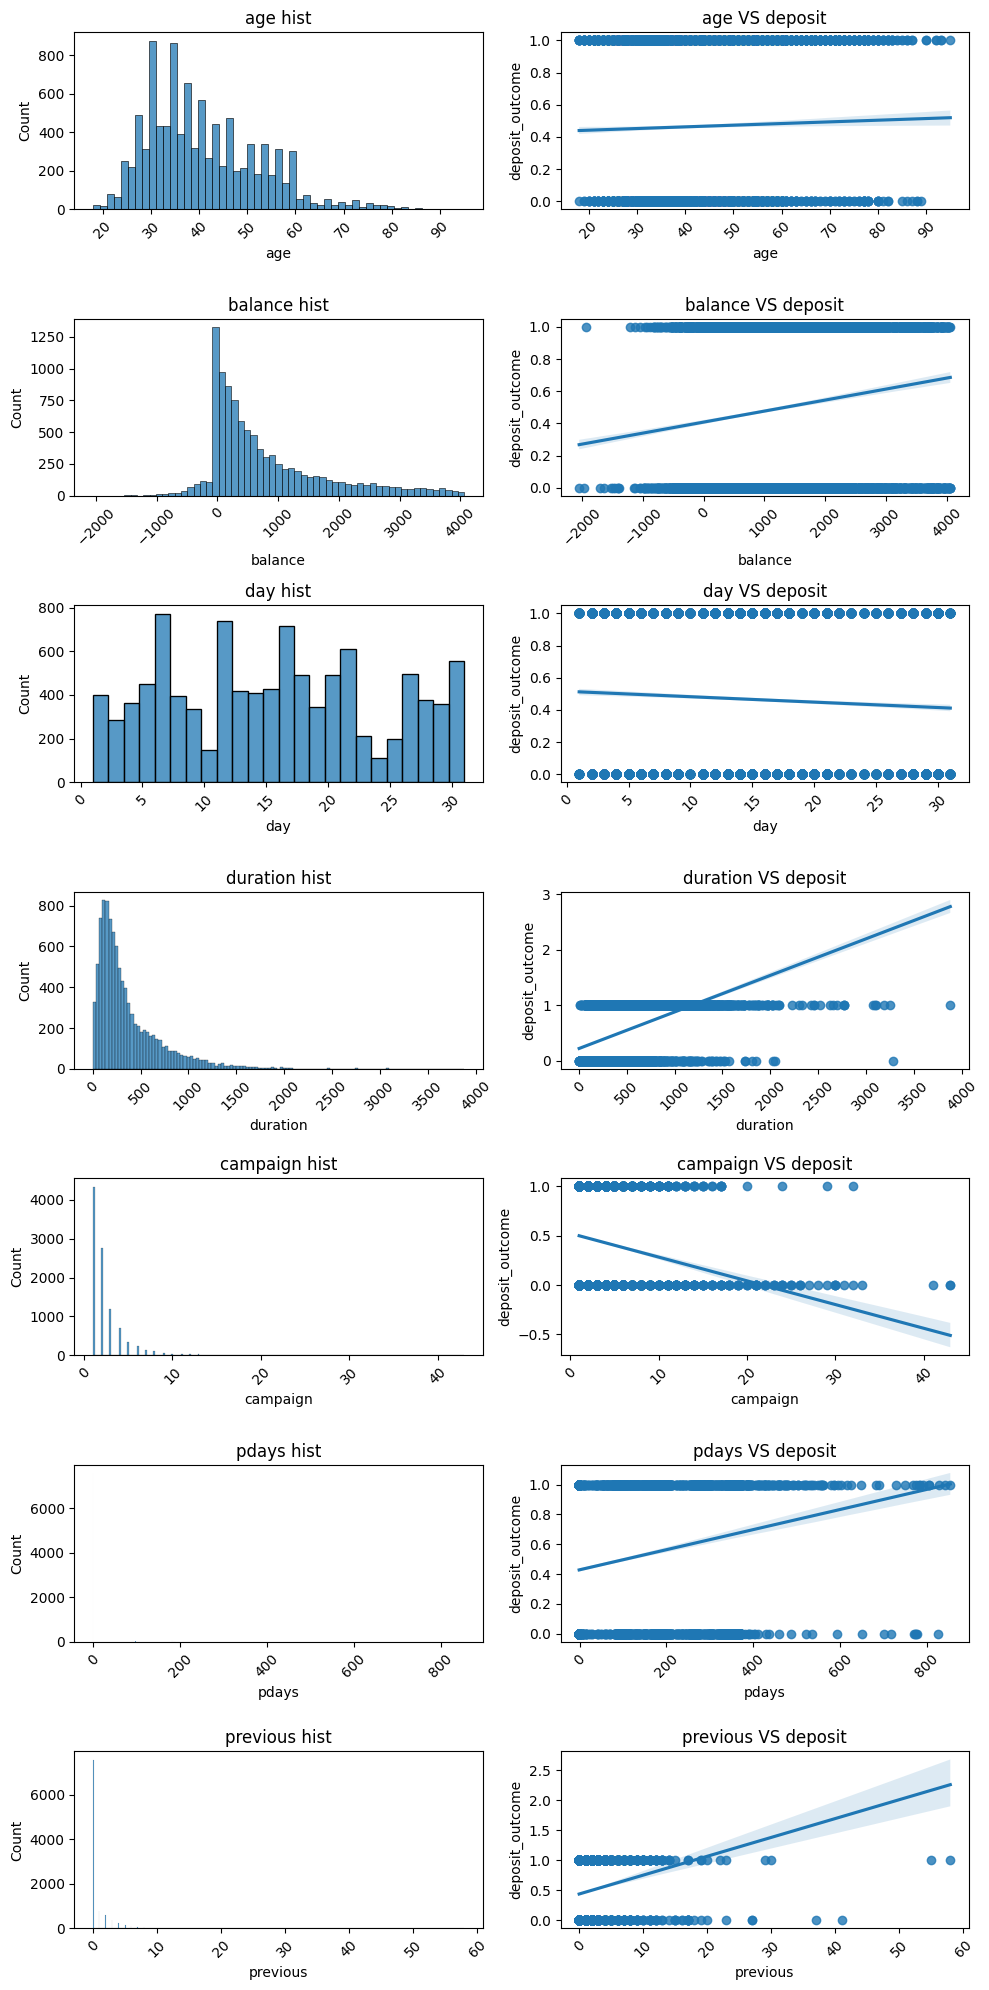

In [ ]:
data['deposit_outcome'] = data['deposit'].apply(lambda x: 1 if x=='yes' else 0)

n = len(numeric_columns) # numerical features
fig, axes = plt.subplots(n, 2, figsize=(10, 20)) 

# Cycle to study features
for i, feature in enumerate(numeric_columns): #i- index, feature
    # histogram
    histplot = sns.histplot(data=data, x=feature, ax=axes[i][0])
    histplot.set_title('{} hist'.format(feature))   
    histplot.xaxis.set_tick_params(rotation=45)
    
    # scatter plot with regression
    regplot = sns.regplot(data=data, x=feature, y='deposit_outcome', ax=axes[i][1])
    regplot.set_title('{} VS deposit'.format(feature));
    regplot.xaxis.set_tick_params(rotation=45)
        
plt.tight_layout() #выравнивание графиков

<Figure size 640x480 with 0 Axes>

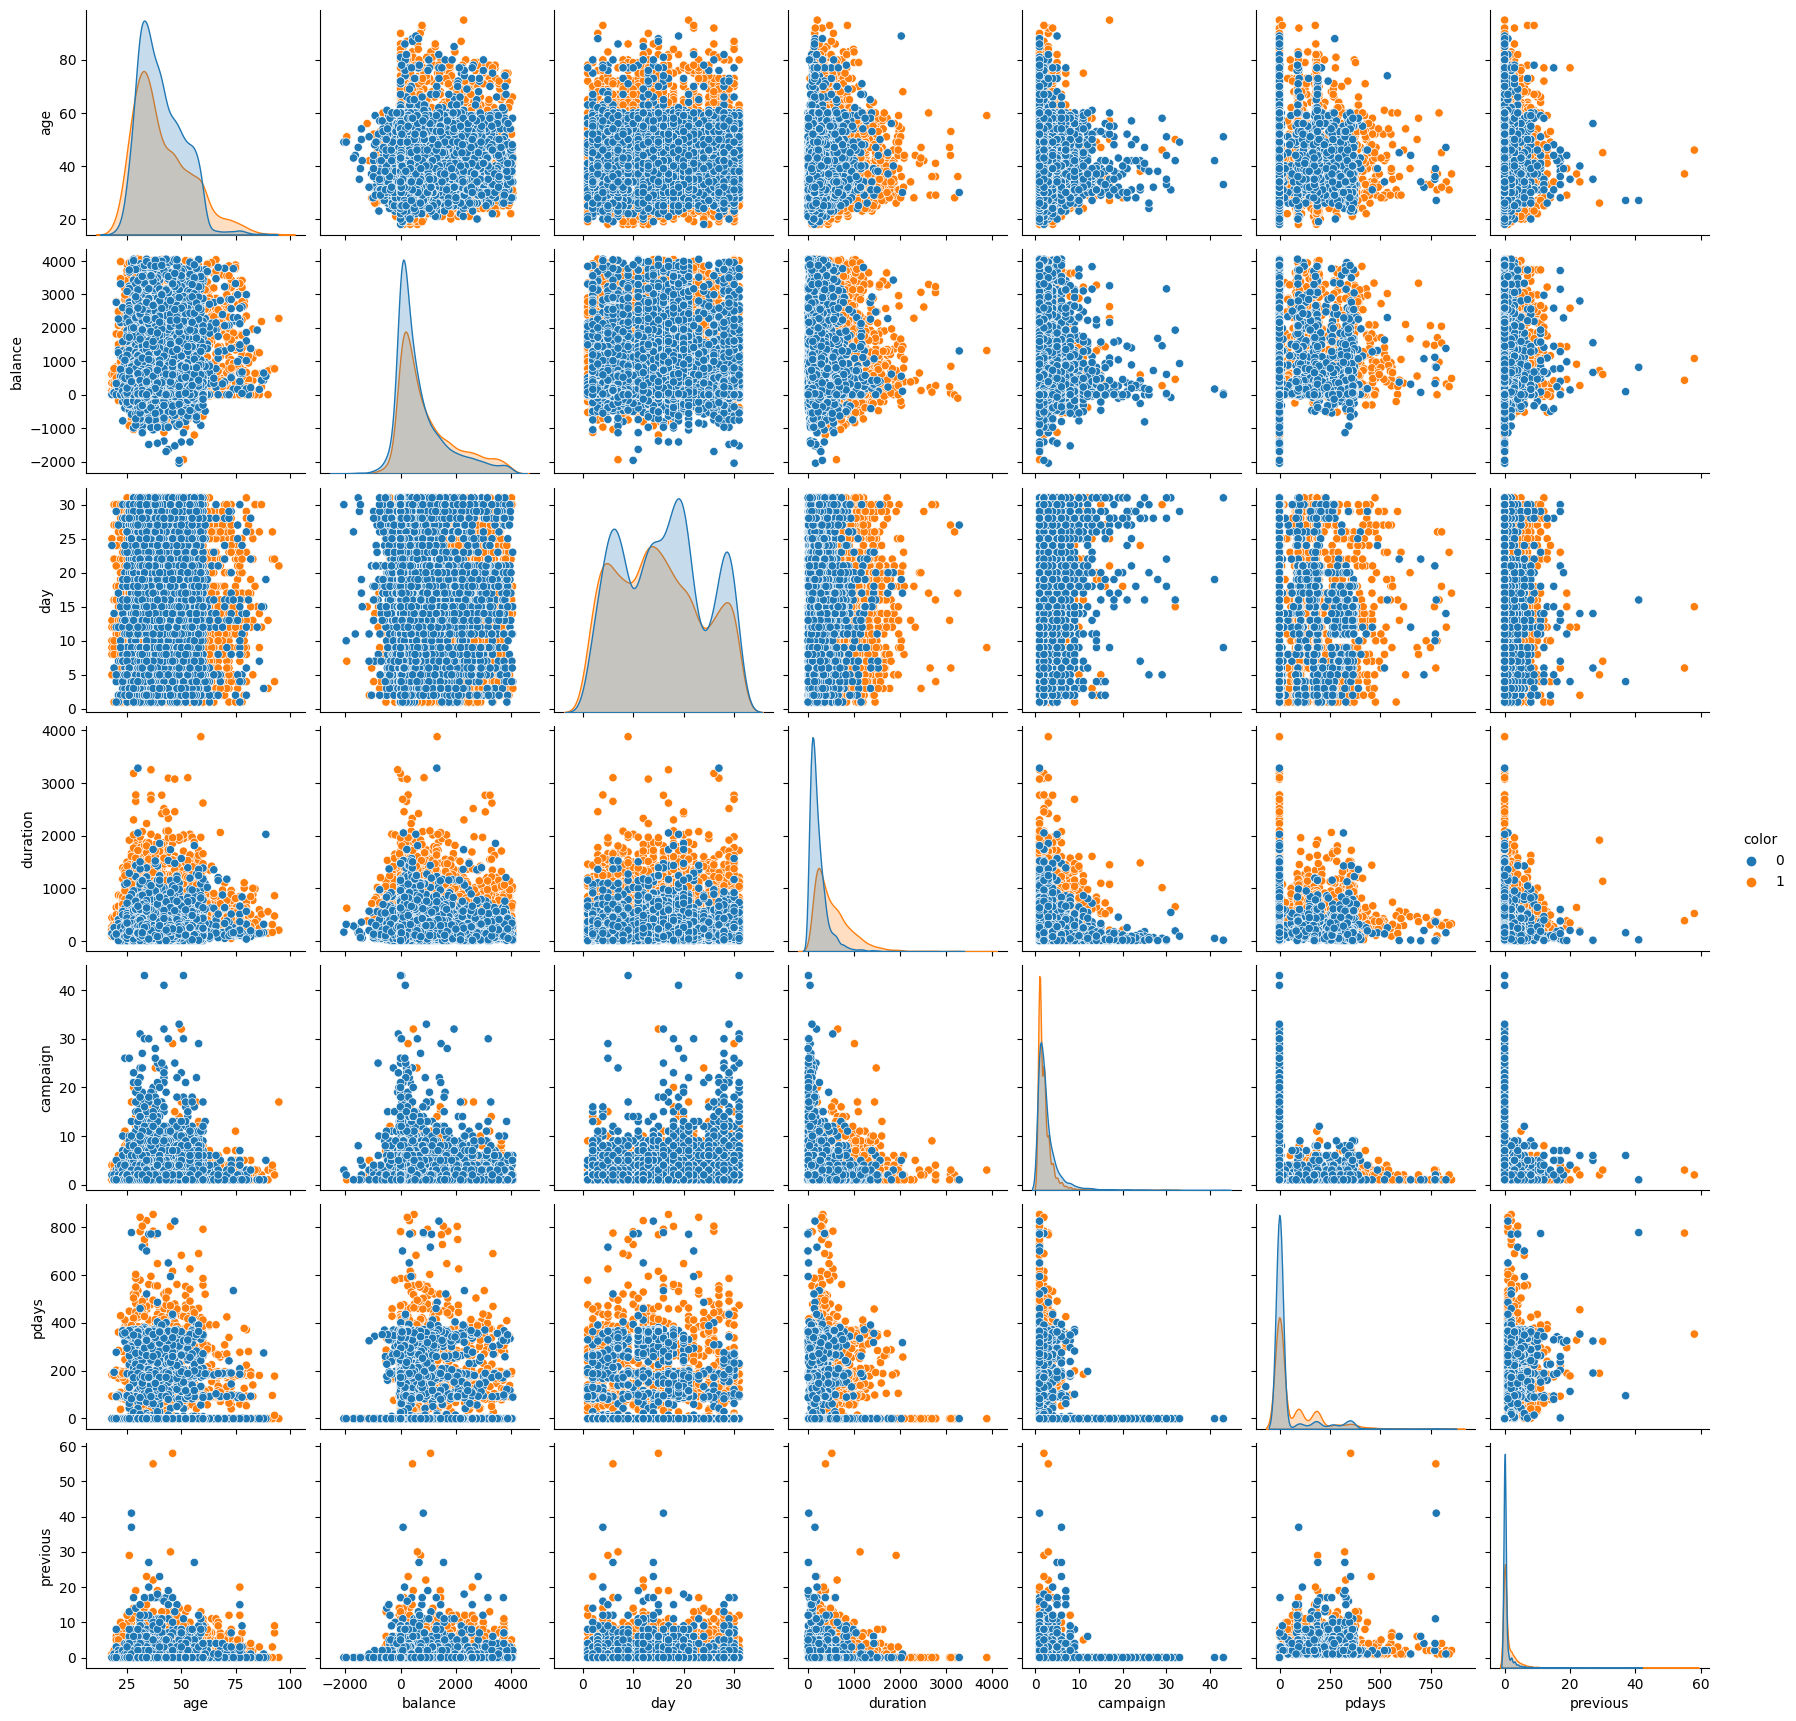

In [ ]:

# data['color'] = data['deposit'].apply(lambda x: 1 if x=='yes' else 0)

# plt.figure()
# sns.pairplot(data[numeric_columns], hue = 'color');
# #plt.show()

### Задания 4 и 5

рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат. Постройте визуализации, иллюстрирующие результаты

In [ ]:
# selection of categorical features
cat_features = [s for s in data.columns if data[s].dtypes == 'object']
data[cat_features].describe().T

,count,unique,top,freq
job,10104,11,management,2314
marital,10104,3,married,5714
education,10104,3,secondary,5517
default,10104,2,no,9938
housing,10104,2,no,5243
loan,10104,2,no,8711
contact,10104,3,cellular,7282
month,10104,12,may,2616
poutcome,10104,4,unknown,7570
deposit,10104,2,no,5423


### month

In [ ]:
data['month'].unique()

array(['may', 'jun', 'jul', 'aug', 'oct', 'nov', 'dec', 'jan', 'feb',
       'mar', 'apr', 'sep'], dtype=object)

Категориальные признаки: 
* **month** - месяц, в котором состоялся последний контакт. В списке присутствуют  12 разных месяцев. При отсутствии уточняющих данных можно предположить, что маркетинговая кампания длилась год.
* 

### Задание 6

In [ ]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# ваш код

### Задание 7

In [ ]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# ваш код

### Задание 8

In [ ]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения

### Задания 9 и 10

In [ ]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса

In [ ]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования

In [ ]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости

### Задание 11

In [ ]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)

## Часть 3: преобразование данных

### Задание 1

In [ ]:
# преобразуйте уровни образования

### Задания 2 и 3

In [ ]:
# преобразуйте бинарные переменные в представление из нулей и единиц

### Задание 4

In [ ]:
# создайте дамми-переменные

### Задания 5 и 6

In [ ]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности

### Задания 7 и 8

In [ ]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [ ]:
# рассчитайте необходимые показатели

### Задание 9

In [ ]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков

### Задание 10

In [ ]:
# нормализуйте данные с помощью minmaxsxaler

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [ ]:
# обучите логистическую регрессию и рассчитайте метрики качества

### Задания 2,3,4

In [ ]:
# обучите решающие деревья, настройте максимальную глубину

### Задание 5

In [ ]:
# подберите оптимальные параметры с помощью gridsearch

# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [ ]:
# обучите на ваших данных случайный лес

### Задания 2 и 3

In [ ]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом

### Задание 4

In [ ]:
# объедините уже известные вам алгоритмы с помощью стекинга 

### Задание 5

In [ ]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

### Задания 6,7,8

In [ ]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna